In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob

In [2]:
def camera_cal(img, nx, ny):
    
    # To map the coordinates of the corners in the 2D image (img in this case) called imgpoints to the 3D coordinates 
    # of the real, undistorted chessboard corners called objpoint
    
    imgpoints = [] # 2D coordinates in image plane    
    objpoints = [] # 3D coordinates in real world space

    
    objp = np.zeros((ny*nx, 3), np.float32)  # (54, 3) 54 points each with 3 columns for the x, y, z coordinates of each corner
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2) # (54, 3) They are filled as (0.,0.,0.), (1.,0.,0.), (2.,0.,0.) ..... (8.,5.,0.)
    
    for image_name in (images):
        image_original = mpimg.imread(image_name)

        # Convert to grayscale
        gray = cv2.cvtColor(image_original, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        # corners = Output array of detected corners. The values returned for first corner of the first image are:
        # [545.3228  343.05032] which is [nx ny]

        # If found, draw corners
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
            image_corner = np.copy(image_original)
            cv2.drawChessboardCorners(image_corner, (nx, ny), corners, ret)

            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,20))
            ax1.imshow(image_original)
            ax1.set_title('image_original', fontsize=15)
            ax2.imshow(image_corner)
            ax2.set_title('image_corner', fontsize=15)
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None) # gray.shape[::-1] reverses shape from (720, 1280) to (1280, 720)
    # ret = 1.0298149716172809
    # mtx = [[1.15777818e+03 0.00000000e+00 6.67113857e+02]
    #        [0.00000000e+00 1.15282217e+03 3.86124583e+02]
    #        [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
    # dist = [k1, k2, p1, p2, k3] -> [[-0.24688507 -0.02373155 -0.00109831  0.00035107 -0.00259868]]
    
    # dist = distortion coefficients
    # mtx = camera matrix that we need to transform 3D object points to 2D image points
    # rvecs (rotation vector), tvecs (translation vector) = denotes position of the camera in the world
    return mtx, dist

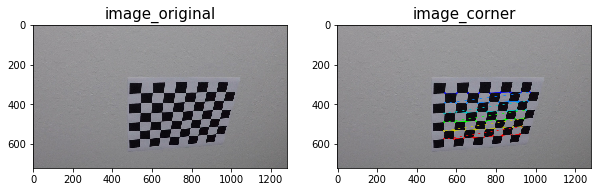

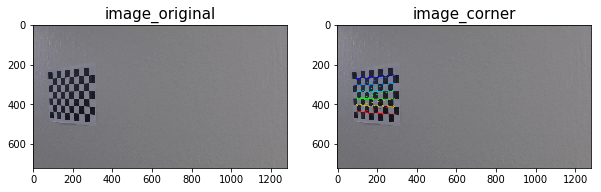

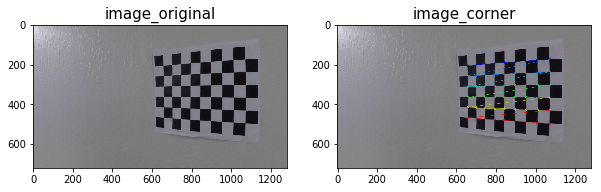

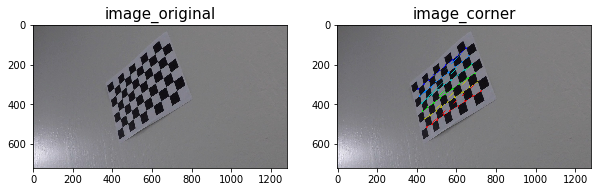

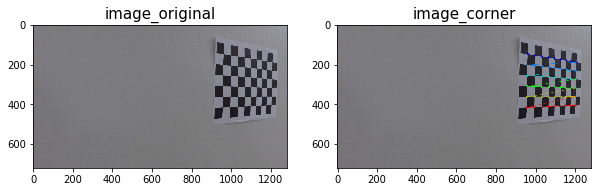

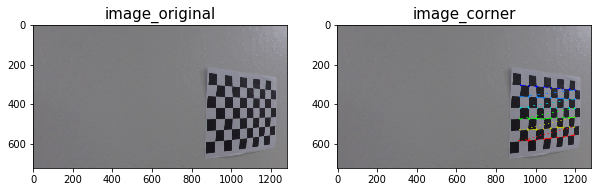

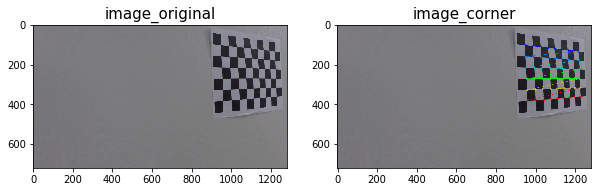

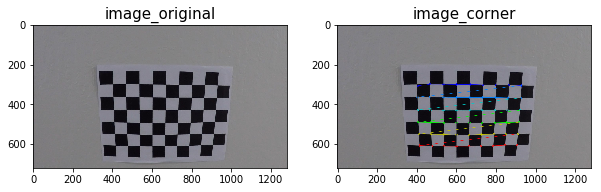

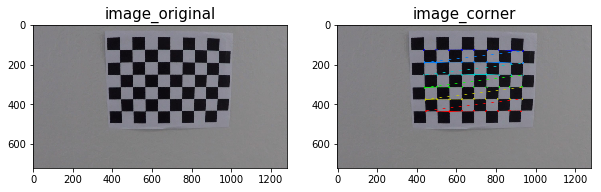

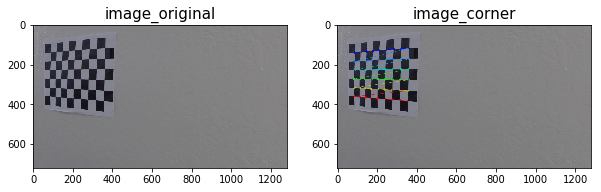

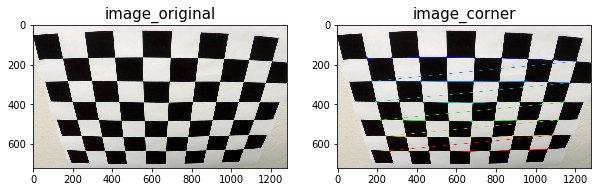

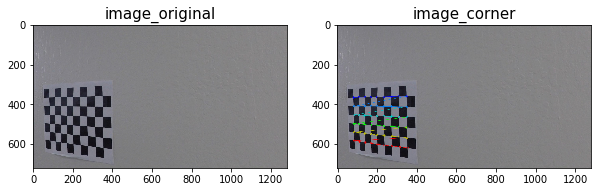

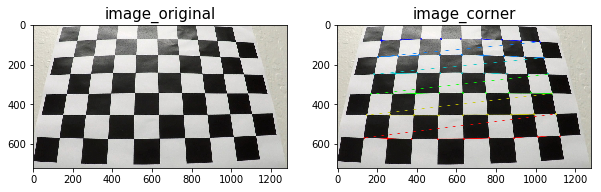

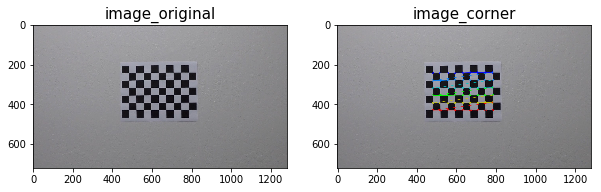

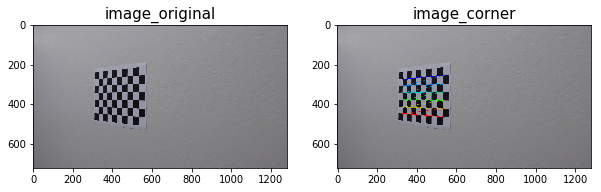

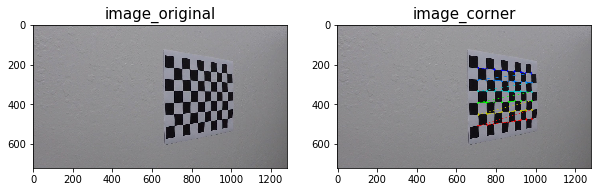

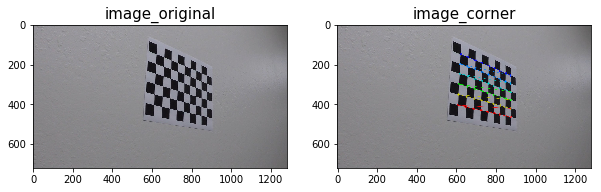

In [3]:
cam_folder = 'camera_cal/'
nx = 9 #enter the number of inside corners in x
ny = 6 #enter the number of inside corners in y

images = glob(cam_folder + '/*.jpg')
mtx, dist = camera_cal(images, nx, ny)

In [4]:
def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

In [5]:
def warp_chessboard(undist, nx, ny):
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret:
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        src = np.float32([corners[0][0], corners[nx - 1][0], corners[-1][0], corners[-nx][0]])
        # print(corners[0][0])                    [710.3549 215.566 ]
        dst = np.float32([[100, 100], [1180,100], [1180, 620], [100, 620]])
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undist, M, gray.shape[::-1], flags=cv2.INTER_LINEAR)
        
    return warped, M

Text(0.5, 1.0, 'undistorted & warped')

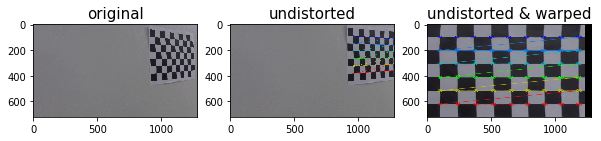

In [6]:
img = mpimg.imread(np.random.choice(images))
undist = undistort(img, mtx, dist)

# A perspective transforms the z coordinate of the object point which in turn changes the object's 2D image representation
# It warps the image & drags points towards or away from camera to change apparent perspective
# For a bird's eye view, we can apply perspective transform. This helps in fiding curvature of lane. It's also helps in 
# matching car's location directly with the map (displays from bird's eye view)

# Select 4 source points that define a rectangle on the source image
# Select 4 destination points on the warped image where you want the 4 source points to appear
# Use opencv to calculate the transform 'M' that maps source points onto destination points
# Apply transform 'M' to the original image to get the warped image using opencv
top_down, perspective_M = warp_chessboard(undist, nx, ny)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 20))
ax1.imshow(img)
ax1.set_title('original', fontsize=15)
ax2.imshow(undist)
ax2.set_title('undistorted', fontsize=15)
ax3.imshow(top_down)
ax3.set_title('undistorted & warped', fontsize=15)

In [7]:
# Create binary thresholded images to isolate lane line pixels
def thresholds(image, show=True):

    s_channel = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,2]
    
    l_channel = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)[:,:,0]

    b_channel = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)[:,:,2]   

    # Threshold color channel
    s_thresh = (200, 255)
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    b_thresh = (150, 220)
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh[0]) & (b_channel <= b_thresh[1])] = 1
    
    l_thresh = (225, 255)
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    c_binary = np.zeros_like(s_binary)
    c_binary[(s_binary == 1) | (l_binary == 1) | (b_binary == 1)] = 1

    return s_binary, b_binary, l_binary, c_binary

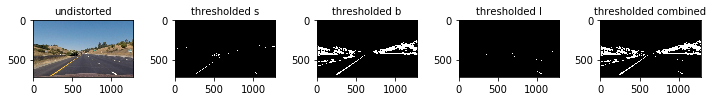

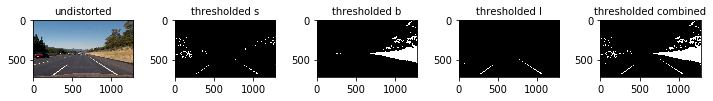

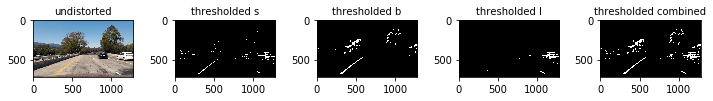

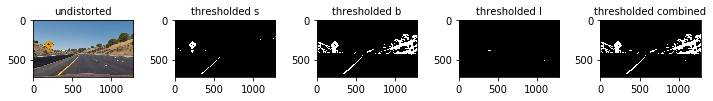

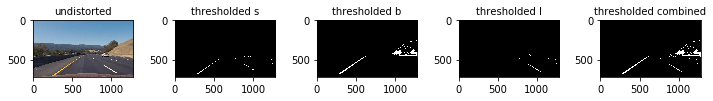

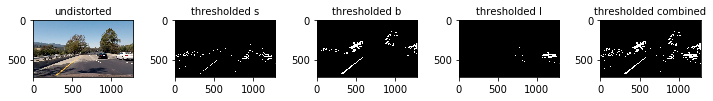

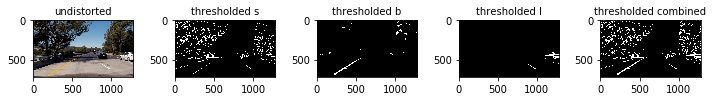

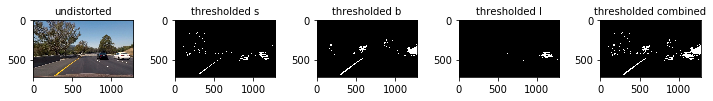

In [8]:
input_folder = 'test_images/'
thresholded_combined = []

for img in glob(input_folder + '/*.jpg'):
    img = mpimg.imread(img)
    undist = undistort(img, mtx, dist)
    s_binary, b_binary, l_binary, c_binary = thresholds(img)
    thresholded_combined.append(c_binary)
    
    f, (ax1, ax2, ax3, ax4, ax5,) = plt.subplots(1, 5, figsize=(10,20))
    f.tight_layout()

    ax1.set_title('undistorted', fontsize=10)
    ax1.imshow(undist)

    ax2.set_title('thresholded s', fontsize=10)
    ax2.imshow(s_binary, cmap='gray')

    ax3.set_title('thresholded b', fontsize=10)
    ax3.imshow(b_binary, cmap='gray')

    ax4.set_title('thresholded l', fontsize=10)
    ax4.imshow(l_binary, cmap='gray')

    ax5.set_title('thresholded combined', fontsize=10)
    ax5.imshow(c_binary, cmap='gray')

In [9]:
def warp_test_images(img):
    
    src = np.float32([[480, 480],[800, 480],
                      [1250, 720],[0, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[0, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img.shape[::-1])

    return warped, M

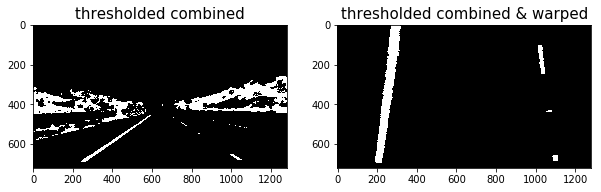

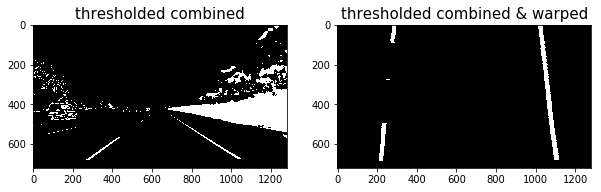

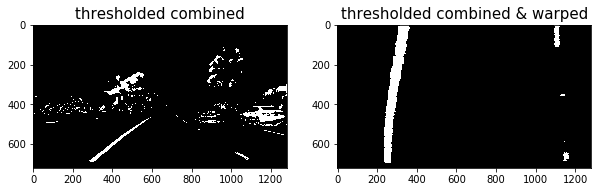

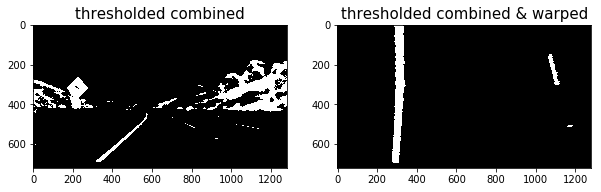

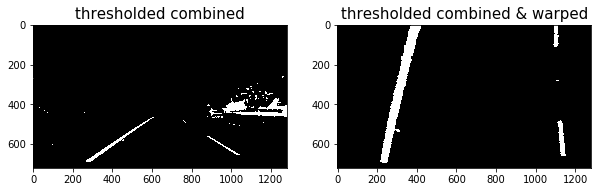

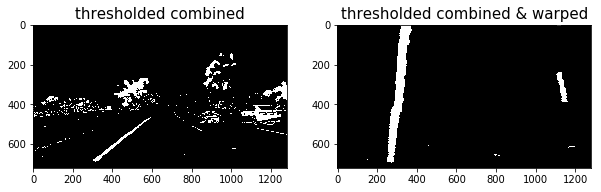

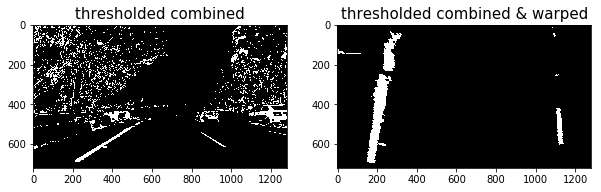

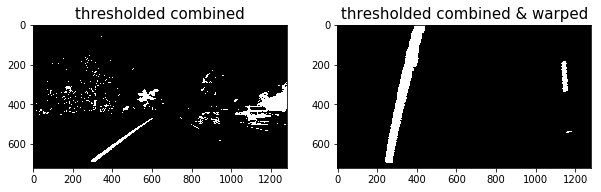

In [10]:
for img in thresholded_combined:
    top_down, perspective_M = warp_test_images(img)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 20))
    ax1.imshow(img, cmap='gray')
    ax1.set_title('thresholded combined', fontsize=15)
    ax2.imshow(top_down, cmap='gray')
    ax2.set_title('thresholded combined & warped', fontsize=15)

In [11]:
def find_lane_pixels(binary_warped):
    
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2)
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return out_img, left_fit, right_fit

In [12]:
def search_from_prior(binary_warped, left_fit, right_fit):
    
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result, left_fitx, right_fitx, ploty

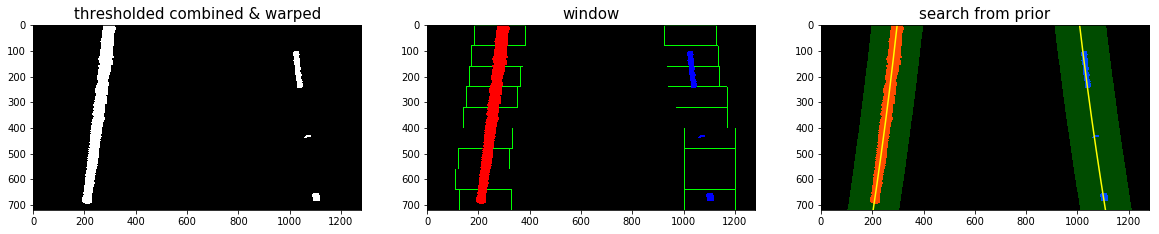

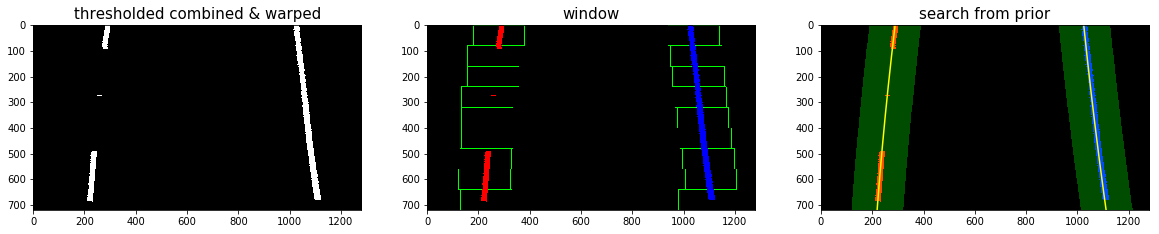

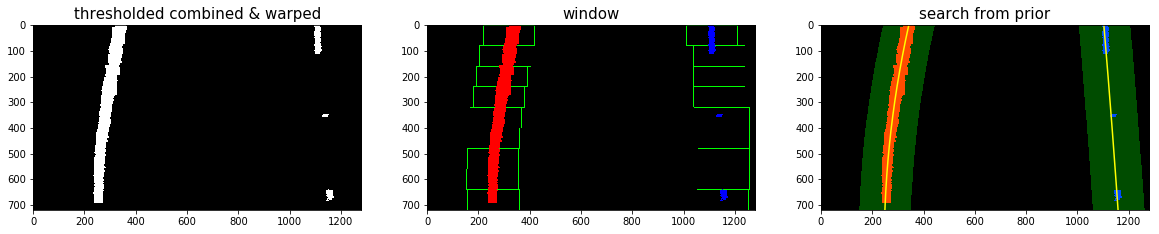

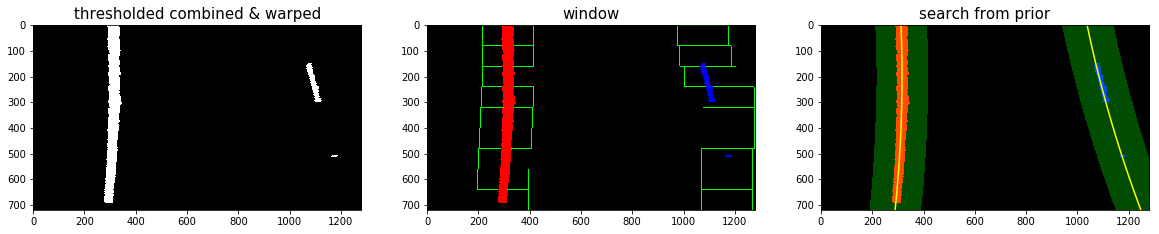

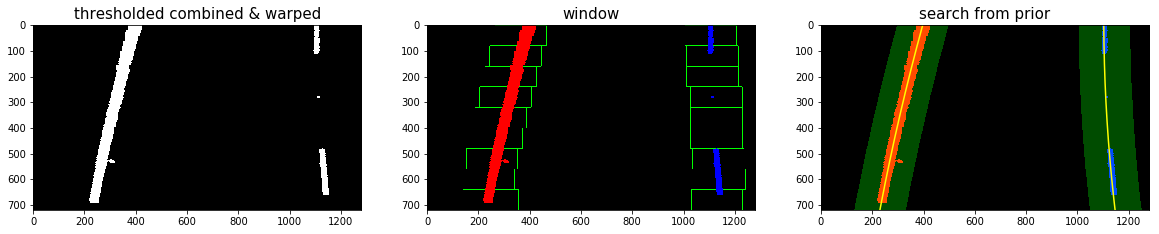

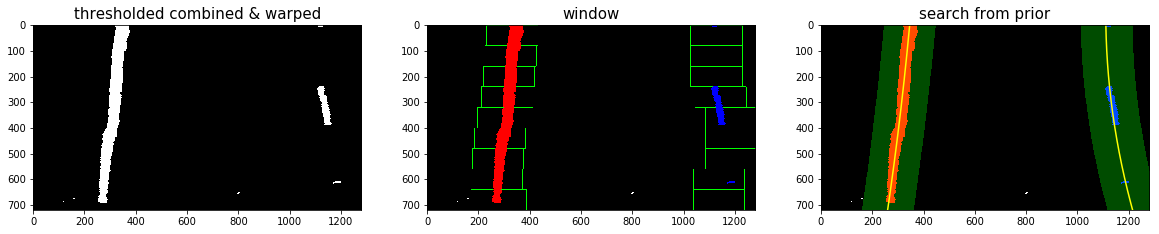

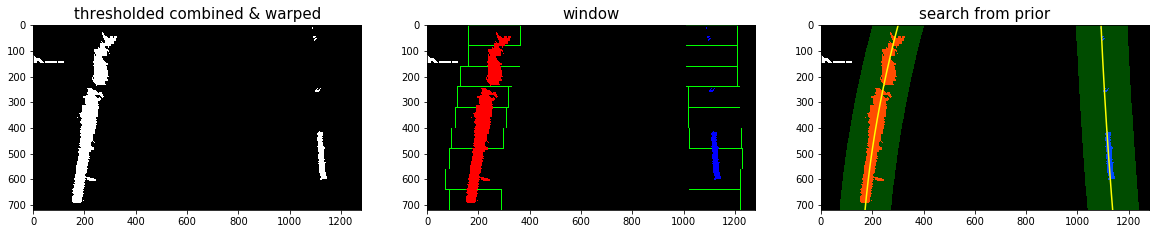

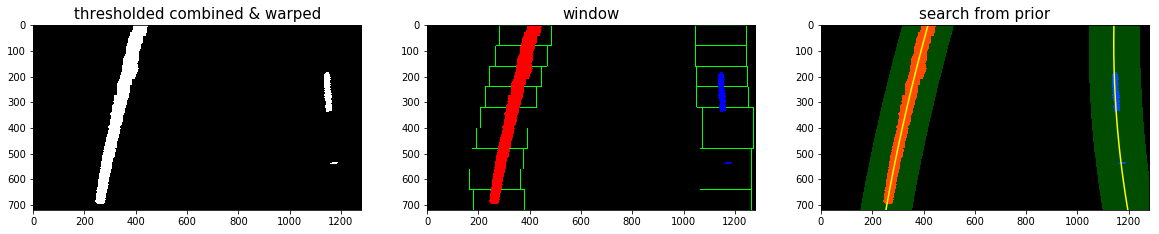

In [13]:
for img in thresholded_combined:
    top_down, perspective_M = warp_test_images(img)
    out_img, left_fit, right_fit = find_lane_pixels(top_down)
    out_img_search, left_fitx, right_fitx, ploty = search_from_prior(top_down, left_fit, right_fit)
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 20))
    ax1.imshow(top_down, cmap='gray')
    ax1.set_title('thresholded combined & warped', fontsize=15)
    ax2.imshow(out_img)
    ax2.set_title('window', fontsize=15)
    ax3.imshow(out_img_search)
    ax3.set_title('search from prior', fontsize=15)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')